# Creating basic visualizations using Matplotlib.

## Import the Matplotlib using the alias <code>plt</code>.

In [5]:
import numpy as np # for creating arrays
import pandas as pd # for manipulating dataframes
import matplotlib.pyplot as plt
%matplotlib inline 

## Line plot

Text(20.200000000000003, 0.5, 'y-axis')

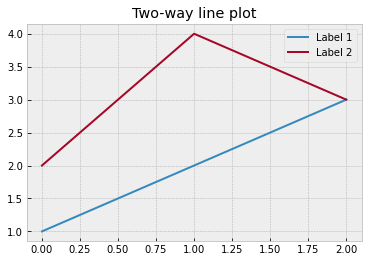

In [37]:
plt.plot([1, 2, 3], label='Label 1')
plt.plot([2, 4, 3], label='Label 2')
plt.legend()
# Add axes and titles
plt.title('Two-way line plot')
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

## Create Scatter Plot

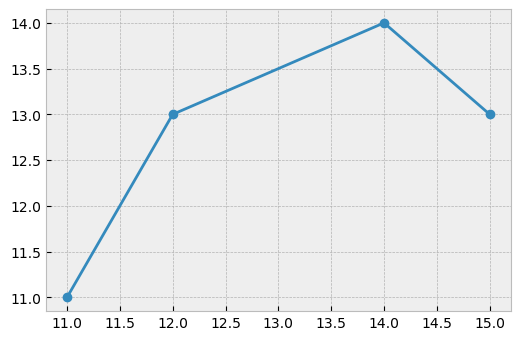

<Figure size 432x288 with 0 Axes>

In [45]:
# Create a Figure with dpi set to 100
ax = plt(figsize=(20, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Price")

plt.figure(dpi=100)
plt.plot([11, 12, 14, 15], [11, 13, 14, 13], '-o')
plt.show()
# Save 
plt.savefig('line_plot.png', bbox_inches='tight')

## Bar Plot

Text(0.5, 1.0, 'Bar chart')

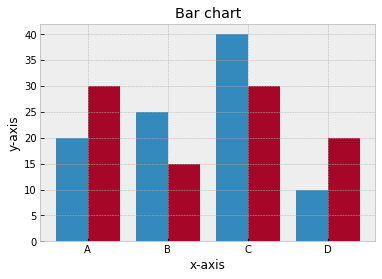

In [36]:
labels = ['A', 'B', 'C', 'D']
x = np.arange(len(labels))
width = 0.4
plt.bar(x - width / 2, [20, 25, 40, 10], width=width)
plt.bar(x + width / 2, [30, 15, 30, 20], width=width)
# Ticks and tick labels must be set manually
plt.xticks(x)
ax = plt.gca()
ax.set_xticklabels(labels)
# Add axes and titles
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

plt.title('Bar chart')

- To create a vertical bar plot use ``` plt.bar(x, height, [width]) ```. 
- To create horizontal bars, use the plt.barh() function.

> - x: represents the x coordinates
> - height: represents the height of the bars
> - width (optional): Specifies the width of all bars. The default is set to 0.8.
> - The ```arange()``` function returns evenly spaced values within a given interval. 
> - The ```gca()``` function generates the instance of current axes. 
> - The ```set_xticklabels()``` function sets the x-tick labels using the list of given string labels.

## Pie Chart

The ```plt.pie(x, [explode], [labels], [autopct])``` function creates a pie chart.

- x: Specifies the slice sizes.
- explode (optional): Specifies the fraction of the radius offset for each slice.
- labels (optional): Specifies the labels for the slices.
- autopct (optional): presents percentages inside the slices in the specified format '%1.1f%%'.

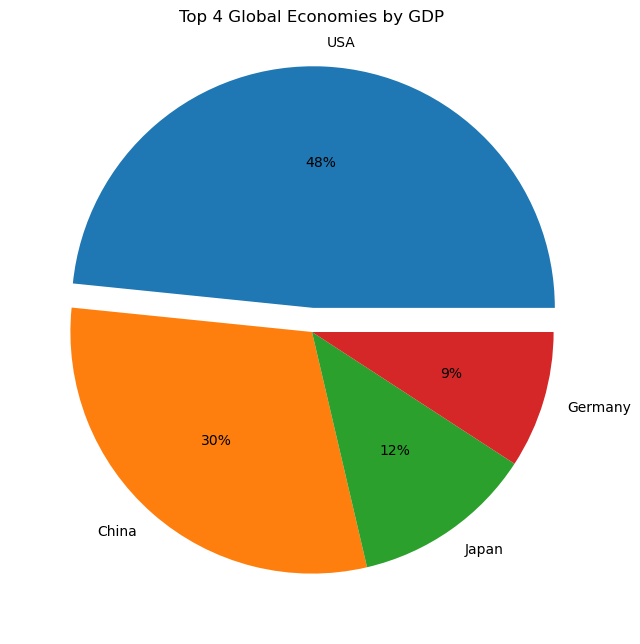

In [25]:
# Create figure
plt.figure(figsize=(8, 8), dpi=100)

plt.pie([19.5, 12.2, 4.9, 3.7], explode=(0.1, 0, 0, 0), \
        labels=['USA', 'China', 'Japan', 'Germany'], autopct='%.0f%%')
# Add title
plt.title('Top 4 Global Economies by GDP')
# Show plot
plt.show()

## Download Stock data from Yahoo Finance!

In [1]:
import yfinance as yf
tickers = ['AAPL', 'GOOG', 'AMZN', 'MSFT']

#Download only adjusted closing price for the tickers
data = yf.download(tickers, start="2020-01-01", end="2022-03-30")['Adj Close']
data.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2019-12-31,72.245941,1847.839966,1337.020020,154.430389
2020-01-02,73.894318,1898.010010,1367.369995,157.289856
2020-01-03,73.175919,1874.969971,1360.660034,155.331329
2020-01-06,73.759010,1902.880005,1394.209961,155.732834
2020-01-07,73.412117,1906.859985,1393.339966,154.312897


## Save data as csv

In [6]:
data.to_csv('data/stocks.csv')

## Import dependencies and activate influxDB python client

In [39]:
# Import required packages and access infuxdb client
from collections import OrderedDict
from csv import DictReader

import rx
from rx import operators as ops

from dotenv import load_dotenv
import os
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS


load_dotenv()
token = os.getenv('INFLUX_TOKEN')
org = os.getenv('ORG')
bucket = os.getenv('BUCKET')

client = InfluxDBClient(url="https://us-east-1-1.aws.cloud2.influxdata.com", token=token, org=org)


## Write a function to write the Data using Point structure

In [14]:

def parse_row(row: OrderedDict):
    """
    This function will parse rows in the CSV file into Point with structure:
        
        financial-analysis, type=ily aapl=72.24, amzn=1847.83, goog=1337.02, msft=154.43 2019-12-31
        
        the csv file is li this:
        Date,AAPL,AMZN,GOOG,MSFT
        2019-12-31,72.24594116210938,1847.8399658203125,1337.02001953125,154.43038940429688
        2020-01-02,73.89431762695312,1898.010009765625,1367.3699951171875,157.28985595703125
        2020-01-03,73.17591857910156,1874.969970703125,1360.6600341796875,155.33132934570312
        2020-01-06,73.7590103149414,1902.8800048828125,1394.2099609375,155.7328338623047
        2020-01-07,73.41211700439453,1906.8599853515625,1393.3399658203125,154.31289672851562
        ...
        
    :param row: row of csv file
    :return: Parsed csv row to Point
         
    """
    return Point("financial-analysis")\
        .tag("type", "stock-daily") \
        .field("aapl", float(row['AAPL'])) \
        .field("amzn", float(row['AMZN'])) \
        .field("goog", float(row['GOOG'])) \
        .field("msft", float(row['MSFT'])) \
        .time(row['Date'])

"""
Convert the stocks.csv into sequence of data point
"""
data = rx \
    .from_iterable(DictReader(open('./data/stocks.csv', 'r'))) \
    .pipe(ops.map(lambda row: parse_row(row)))

"""
Create client that writes data in batches with 5,000 items.
"""
write_api = client.write_api(write_options=WriteOptions(batch_size=5_000, flush_interval=1_000))

"""
Write data into InfluxDB
"""
write_api.write(bucket=bucket, record=data)
write_api.close()

## Write a Flux Query to return all data in the financial-analysis table

In [17]:
query_with_multiple_fields ='''
from(bucket: "finance-bucket")
  |> range(start:0, stop: now())
  |> filter(fn: (r) => r._measurement == "financial-analysis")
'''

In [23]:
df = client.query_api().query_data_frame(org=org, query=query_with_multiple_fields)
df.head(25)

,result,table,_start,_stop,_time,_value,_field,_measurement,type
0,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2019-12-31 00:00:00+00:00,1847.839966,amzn,financial-analysis,stock-daily
1,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-02 00:00:00+00:00,1898.010010,amzn,financial-analysis,stock-daily
2,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-03 00:00:00+00:00,1874.969971,amzn,financial-analysis,stock-daily
3,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-06 00:00:00+00:00,1902.880005,amzn,financial-analysis,stock-daily
4,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-07 00:00:00+00:00,1906.859985,amzn,financial-analysis,stock-daily
5,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-08 00:00:00+00:00,1891.969971,amzn,financial-analysis,stock-daily
6,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-09 00:00:00+00:00,1901.050049,amzn,financial-analysis,stock-daily
7,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-10 00:00:00+00:00,1883.160034,amzn,financial-analysis,stock-daily
8,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-13 00:00:00+00:00,1891.300049,amzn,financial-analysis,stock-daily
9,_result,0,1970-01-01 00:00:00+00:00,2022-03-31 22:43:59.126268+00:00,2020-01-14 00:00:00+00:00,1869.439941,amzn,financial-analysis,stock-daily


## Write a Flux Query to pivot the time series into a dataframe

In [24]:
query_with_pivot ='''
from(bucket: "finance-bucket")
  |> range(start:0, stop: now())
  |> filter(fn: (r) => r._measurement == "financial-analysis")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns:["_time", "aapl", "amzn", "goog", "msft"])
'''

In [25]:
df = client.query_api().query_data_frame(org=org, query=query_with_pivot)
df.head(25)

,result,table,_time,aapl,amzn,goog,msft
0,_result,0,2019-12-31 00:00:00+00:00,72.245941,1847.839966,1337.020020,154.430389
1,_result,0,2020-01-02 00:00:00+00:00,73.894318,1898.010010,1367.369995,157.289856
2,_result,0,2020-01-03 00:00:00+00:00,73.175919,1874.969971,1360.660034,155.331329
3,_result,0,2020-01-06 00:00:00+00:00,73.759010,1902.880005,1394.209961,155.732834
4,_result,0,2020-01-07 00:00:00+00:00,73.412117,1906.859985,1393.339966,154.312897
5,_result,0,2020-01-08 00:00:00+00:00,74.593040,1891.969971,1404.319946,156.770859
6,_result,0,2020-01-09 00:00:00+00:00,76.177467,1901.050049,1419.829956,158.729401
7,_result,0,2020-01-10 00:00:00+00:00,76.349670,1883.160034,1429.729980,157.994965
8,_result,0,2020-01-13 00:00:00+00:00,77.980835,1891.300049,1439.229980,159.894745
9,_result,0,2020-01-14 00:00:00+00:00,76.927849,1869.439941,1430.880005,158.768585


## Drop the 'result' and 'table' columns to retain the relevant columns

In [26]:
df["_time"] = pd.to_datetime(df["_time"].astype(str))
df = df.drop(columns=["result", "table"])
df = df.set_index("_time")
df.head()

,aapl,amzn,goog,msft
_time,,,,
2019-12-31 00:00:00+00:00,72.245941,1847.839966,1337.020020,154.430389
2020-01-02 00:00:00+00:00,73.894318,1898.010010,1367.369995,157.289856
2020-01-03 00:00:00+00:00,73.175919,1874.969971,1360.660034,155.331329
2020-01-06 00:00:00+00:00,73.759010,1902.880005,1394.209961,155.732834
2020-01-07 00:00:00+00:00,73.412117,1906.859985,1393.339966,154.312897


## Normalize the df to create professional charts

The dataframe shows that AMZN and GOOGLE stock prices are in thousands while AAPL and MSFT have their stock prices in tens and hundreds. Plotting the data will have two charts at the top (AAPL and GOOGLE) and two charts at the bottom (MSFT and GOOG). The chart will look unprofessional. To get over this problem, you can normalize the stock data with reference to day 1, forcing first day price to start at $1. 

In [27]:
def normalize_df(df):
    """normalizes stock data w.r.t price in day 1, 
    force first day price to start at $1"""
    return df/df.iloc[0,:]

data = normalize_df(df)

## Create time series plots

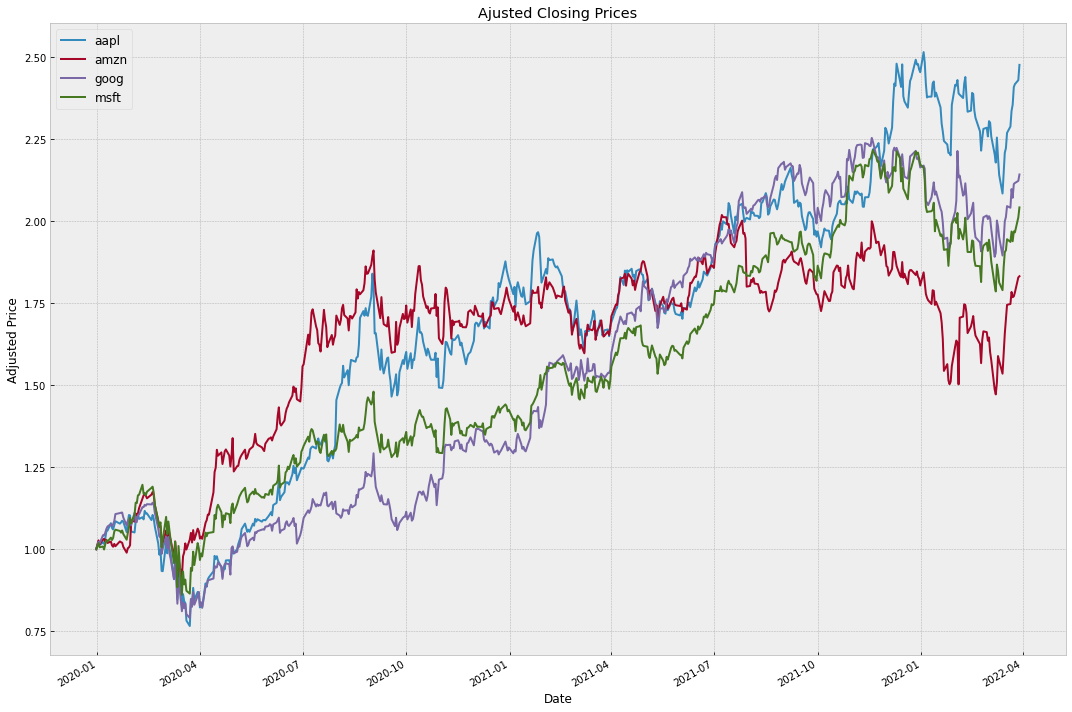

In [30]:
# Create the plot
ax = data.plot(figsize=(15, 10))
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Price")

plt.title('Ajusted Closing Prices')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.style.use('bmh')
plt.grid(True)
plt.show()

## Analysis

There was a temporary decline in prices between March and April 2020, when governments anounced lockdown measures due to COVID-19. Technology stocks have performed relatively well, notwithstanding the effects of COVID-19. 